[Load] /mnt/cephfs-mount/chenchen/merged_with_era5_full_clear.csv
 Loading and preprocessing data (RAW_FEATURES only)...
✅ Preprocessing done. Features: 24  Samples: 3,995,321
[Split saved] /mnt/cephfs-mount/chenchen/xgb_wfrac_gpu_preproc_runs_1104/run_20251107_021951/split_idx.npz
[Split] train/val/test = 2796724/599298/599299
[Features after preprocessing] 24 cols

=== Single Model Evaluation ===
[Train-RAW] R=0.8899 | R2=0.7867 | MAE=0.064195 | RMSE=0.103666
[Val-RAW] R=0.8160 | R2=0.6653 | MAE=0.079320 | RMSE=0.129903
[Test-RAW] R=0.8161 | R2=0.6656 | MAE=0.079355 | RMSE=0.130077
[Test-CALIB] R=0.8172 | R2=0.8172 | MAE=0.076425 | RMSE=0.129636

 Observed vs Predicted (density, log scale)


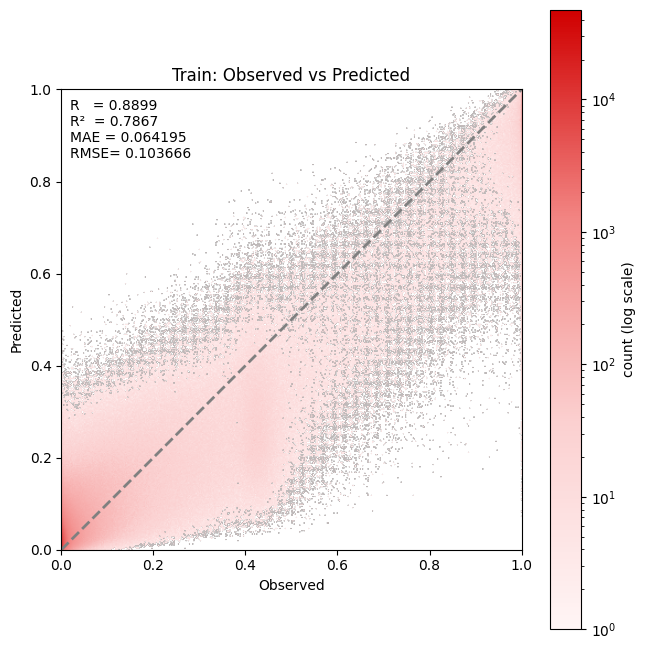

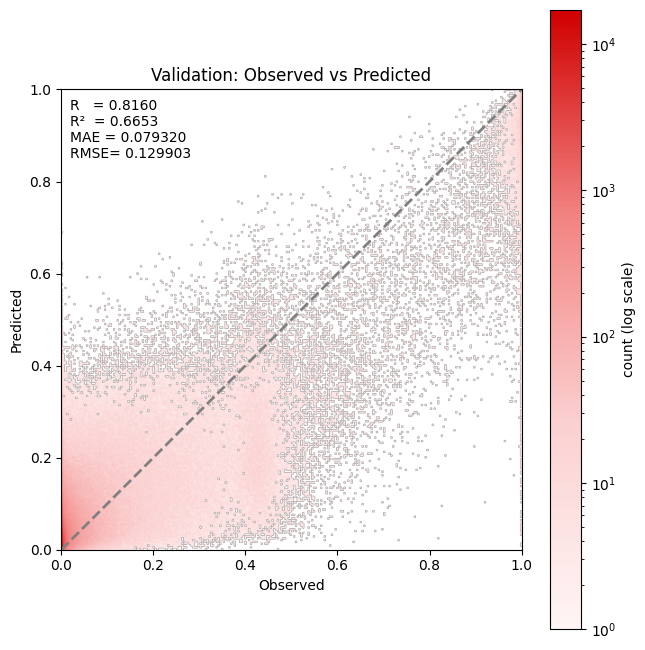

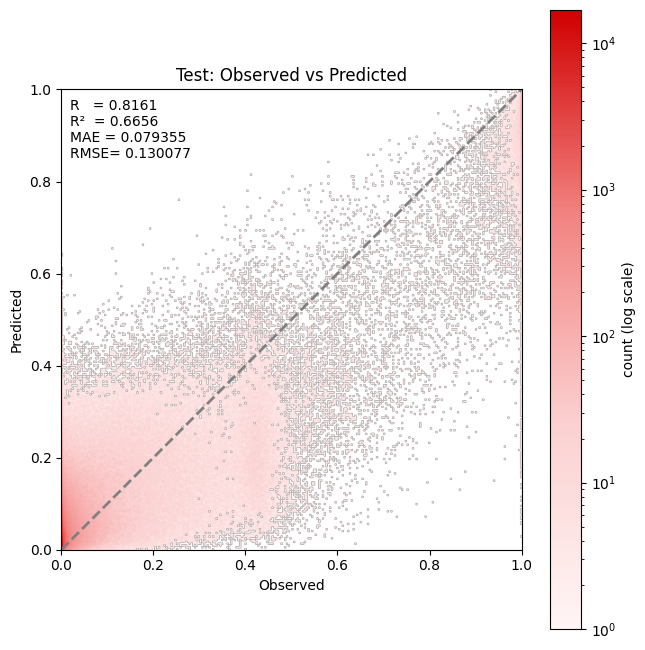

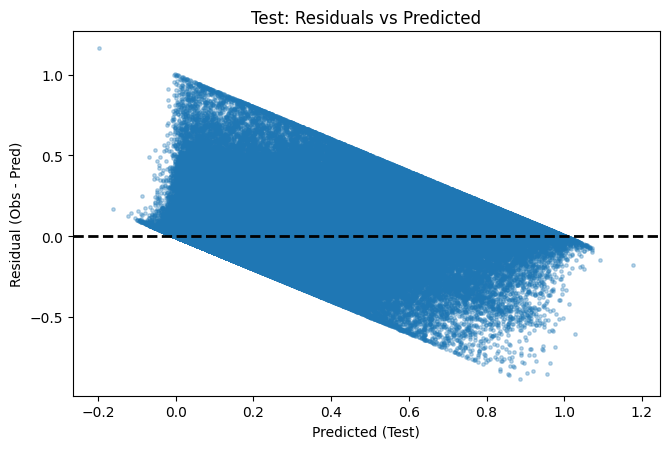

[Warn] SHAP plotting skipped: No module named 'shap'

Top-20 Features (Model importance):
   feature  importance
      lc_0    0.139368
   lat_sin    0.126032
   lon_cos    0.110122
   lat_cos    0.109334
   lon_sin    0.107098
     lc_16    0.100683
      lc_9    0.026775
   ddm_snr    0.026037
     lc_12    0.024304
srtm_slope    0.020833
     lc_15    0.019619
      lc_7    0.019544
     lc_14    0.017400
      lc_5    0.016945
julian_sin    0.016512
     lc_10    0.016458
julian_cos    0.015611
     lc_11    0.015340
     lc_13    0.014769
      lc_2    0.013852

[Saved] /mnt/cephfs-mount/chenchen/xgb_wfrac_gpu_preproc_runs_1104/run_20251107_021951
[Time] 2.1 min


In [ ]:
# -*- coding: utf-8 -*-

import os, json, warnings, math, time, random
from datetime import datetime
warnings.filterwarnings("ignore")

# ============== GPU ==============
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# ===========================
PATH = "/mnt/cephfs-mount/chenchen/merged_with_era5_full_clear.csv"
BASE_OUT = "/mnt/cephfs-mount/chenchen/xgb_wfrac_gpu_preproc_runs_1104"
os.makedirs(BASE_OUT, exist_ok=True)
RUN_DIR = os.path.join(BASE_OUT, datetime.now().strftime("run_%Y%m%d_%H%M%S"))
os.makedirs(RUN_DIR, exist_ok=True)

# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.isotonic import IsotonicRegression
from joblib import dump
from xgboost import XGBRegressor

# ===========================
SEED = 42
random.seed(SEED); np.random.seed(SEED)

FIXED_PARAMS = dict(
    n_estimators=3200,
    learning_rate=0.06,
    max_depth=11,
    min_child_weight=25,
    subsample=0.9,
    colsample_bytree=0.7,
    gamma=0.0,
    reg_alpha=0.0,
    reg_lambda=3.0,
    max_bin=384,
)

USE_STRATIFY_BINS    = True
USE_QUANTILE_WEIGHTS = True
USE_ARCSIN_SQRT      = False
USE_ISOTONIC_CALIB   = True

PLOT_SHAP        = True     # SHAP
SHAP_BG_MAX_N    = 20000    
SHAP_PLOT_MAX_N  = 50000    
DENSITY_MINCNT   = 3       
DENSITY_VMIN     = 1        
DENSITY_VMAX     = None     

# ============================
HEAT_CMAP = LinearSegmentedColormap.from_list(
    "heat", ["#fff5f5", "#fbd0d0", "#f28482", "#d00000"]
)

# ============================
def _pearson_r(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=np.float64)
    y_pred = np.asarray(y_pred, dtype=np.float64)
    if y_true.size < 2 or np.std(y_true) == 0 or np.std(y_pred) == 0:
        return np.nan
    return float(np.corrcoef(y_true, y_pred)[0, 1])

def metrics(y_true, y_pred):
    return dict(
        r    = _pearson_r(y_true, y_pred),
        r2   = float(r2_score(y_true, y_pred)),
        mae  = float(mean_absolute_error(y_true, y_pred)),
        rmse = float(mean_squared_error(y_true, y_pred) ** 0.5),
    )

def make_quantile_bins(y, n_bins=10):
    qs = np.linspace(0, 1, n_bins + 1)
    edges = np.unique(np.quantile(y, qs))
    return np.digitize(y, edges[1:-1], right=True)

def quantile_weights(y, n_bins=10):
    bins = make_quantile_bins(y, n_bins)
    cnt = np.bincount(bins, minlength=n_bins).astype(np.float64)
    w = 1.0 / (cnt[bins] + 1e-9)
    return (w / w.mean()).astype(np.float32)

def to_asin_sqrt(p):
    return np.arcsin(np.sqrt(np.clip(p, 0.0, 1.0))).astype(np.float32)

def inv_asin_sqrt(z):
    s = np.sin(np.clip(z, 0.0, np.pi/2))
    return np.clip(s*s, 0.0, 1.0).astype(np.float32)

def to_jsonable(obj):
    if isinstance(obj, np.generic): return obj.item()
    if isinstance(obj, np.ndarray): return obj.tolist()
    if isinstance(obj, dict): return {k: to_jsonable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple, set)): return [to_jsonable(x) for x in obj]
    return obj

# ============== 仅用 RAW_FEATURES 的预处理 ==============
RAW_FEATURES = ["julian_day","sp_lon","sp_lat","ddm_snr","modis_land_cover","srtm_slope"]
TARGET = "water_fraction"

def load_and_preprocess(path):
    print(" Loading and preprocessing data (RAW_FEATURES only)...")
    usecols = RAW_FEATURES + [TARGET]
    dtype_map = {c: "float32" for c in usecols}
    df = pd.read_csv(path, usecols=usecols, dtype=dtype_map, low_memory=False)

    df[TARGET]      = pd.to_numeric(df[TARGET], errors="coerce").clip(0,1).astype("float32")
    df["ddm_snr"]   = pd.to_numeric(df["ddm_snr"], errors="coerce").clip(0,60).astype("float32")
    df["srtm_slope"]= pd.to_numeric(df["srtm_slope"], errors="coerce").astype("float32")
    df["sp_lon"]    = pd.to_numeric(df["sp_lon"], errors="coerce").astype("float32")
    df["sp_lat"]    = pd.to_numeric(df["sp_lat"], errors="coerce").astype("float32")

    jd = pd.to_numeric(df["julian_day"], errors="coerce").round().clip(1,366)
    df["julian_day"] = jd.fillna(1).astype("int16")

    lc = pd.to_numeric(df["modis_land_cover"], errors="coerce").round()
    df["modis_land_cover"] = lc.fillna(-1).astype("int16")  # -1 缺省类

    df = df.dropna().reset_index(drop=True)

    twopi = 2.0 * math.pi
    day_den = 365.25
    jd_f = df["julian_day"].astype("float32")
    df["julian_cos"] = np.cos(twopi * jd_f / day_den).astype("float32")
    df["julian_sin"] = np.sin(twopi * jd_f / day_den).astype("float32")

    lon_rad = np.radians(df["sp_lon"].astype("float32"))
    lat_rad = np.radians(df["sp_lat"].astype("float32"))
    df["lon_cos"] = np.cos(lon_rad).astype("float32")
    df["lon_sin"] = np.sin(lon_rad).astype("float32")
    df["lat_cos"] = np.cos(lat_rad).astype("float32")
    df["lat_sin"] = np.sin(lat_rad).astype("float32")

    # land cover -> one-hot
    lc_ohe = pd.get_dummies(df["modis_land_cover"].astype("int16"), prefix="lc", dtype=np.uint8)
    df = pd.concat([df.drop(columns=["modis_land_cover"]), lc_ohe], axis=1)

    feature_cols = [
        "ddm_snr","srtm_slope",
        "julian_cos","julian_sin",
        "lon_cos","lon_sin","lat_cos","lat_sin",
    ] + [c for c in df.columns if c.startswith("lc_")]

    for c in ["ddm_snr","srtm_slope","julian_cos","julian_sin","lon_cos","lon_sin","lat_cos","lat_sin"]:
        df[c] = df[c].astype("float32")

    X = df[feature_cols].astype("float32").values
    y = df[TARGET].astype("float32").values
    print(f"✅ Preprocessing done. Features: {len(feature_cols)}  Samples: {len(y):,}")
    return X, y, feature_cols

# ============================
def plot_density_2d(obs, pred, title, bins=None, vmin=1, vmax=None, xyrange=(0,1), mincnt=0):
    obs = np.asarray(obs, dtype=np.float32); pred = np.asarray(pred, dtype=np.float32)
    if bins is None:
        n = len(obs); bins = int(np.clip(np.sqrt(n)/4, 256, 1024))
    H, xe, ye = np.histogram2d(
        obs, pred, bins=bins,
        range=[[xyrange[0], xyrange[1]], [xyrange[0], xyrange[1]]]
    )
    A = np.ma.masked_less(H, mincnt) if mincnt > 0 else H

    plt.figure(figsize=(6.6,6.6))
    im = plt.imshow(
        A.T, origin="lower",
        extent=[xe[0], xe[-1], ye[0], ye[-1]],
        aspect="equal",
        cmap=HEAT_CMAP,
        norm=LogNorm(vmin=max(vmin,1e-12), vmax=vmax)
    )
    cb = plt.colorbar(im); cb.set_label("count (log scale)")
    lo, hi = xyrange
    plt.plot([lo, hi], [lo, hi], color="gray", lw=2, ls="--")  # 更柔和的基准线
    plt.xlabel("Observed"); plt.ylabel("Predicted"); plt.title(title)

    # 左上角统计文本
    m = metrics(obs, pred)
    txt = f"R   = {m['r']:.4f}\nR²  = {m['r2']:.4f}\nMAE = {m['mae']:.6f}\nRMSE= {m['rmse']:.6f}"
    ax = plt.gca()
    ax.text(0.02, 0.98, txt, ha="left", va="top", transform=ax.transAxes,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.85))
    plt.tight_layout(); plt.show()

# ===========================
def main():
    t0 = time.time()
    print(f"[Load] {PATH}")
    X_all, y_all, feature_cols = load_and_preprocess(PATH)

    if USE_ARCSIN_SQRT:
        y_all_fitspace = to_asin_sqrt(y_all)
        print("[Info] Using arcsin–sqrt transform for training (metrics in original space).")
    else:
        y_all_fitspace = y_all

    split_path = os.path.join(RUN_DIR, "split_idx.npz")
    if not os.path.exists(split_path):
        if USE_STRATIFY_BINS:
            y_bins = make_quantile_bins(y_all, 10)
            X_tr, X_tmp, y_tr, y_tmp, idx_tr, idx_tmp = train_test_split(
                X_all, y_all, np.arange(len(y_all)),
                test_size=0.30, random_state=SEED, shuffle=True, stratify=y_bins
            )
            y_bins_tmp = make_quantile_bins(y_tmp, 10)
            X_va, X_te, y_va, y_te, idx_va, idx_te = train_test_split(
                X_tmp, y_tmp, idx_tmp,
                test_size=0.50, random_state=SEED, shuffle=True, stratify=y_bins_tmp
            )
            train_idx, val_idx, test_idx = idx_tr, idx_va, idx_te
        else:
            idx = np.arange(len(y_all))
            rs = np.random.RandomState(SEED); rs.shuffle(idx)
            n_tr = int(0.80*len(idx)); n_va = int(0.10*len(idx))
            train_idx, val_idx, test_idx = idx[:n_tr], idx[n_tr:n_tr+n_va], idx[n_tr+n_va:]
        np.savez(split_path, train=train_idx, val=val_idx, test=test_idx)
        print(f"[Split saved] {split_path}")
    else:
        print(f"[Split exists] {split_path}")

    spl = np.load(split_path)
    train_idx, val_idx, test_idx = spl["train"], spl["val"], spl["test"]
    X_train, y_train = X_all[train_idx], y_all[train_idx]
    X_val,   y_val   = X_all[val_idx],   y_all[val_idx]
    X_test,  y_test  = X_all[test_idx],  y_all[test_idx]

    if USE_ARCSIN_SQRT:
        y_train_fit = to_asin_sqrt(y_train); y_val_fit = to_asin_sqrt(y_val); y_test_fit = to_asin_sqrt(y_test)
    else:
        y_train_fit, y_val_fit, y_test_fit = y_train, y_val, y_test

    w_train = quantile_weights(y_train, 10) if USE_QUANTILE_WEIGHTS else None

    print(f"[Split] train/val/test = {len(train_idx)}/{len(val_idx)}/{len(test_idx)}")
    print(f"[Features after preprocessing] {len(feature_cols)} cols")

    model = XGBRegressor(
        tree_method="gpu_hist", predictor="gpu_predictor",
        random_state=SEED, n_jobs=-1, **FIXED_PARAMS
    )
    model.fit(
        X_train, y_train_fit,
        sample_weight=w_train,
        eval_set=[(X_val, y_val_fit)],
        eval_metric=["rmse","mae"],
        early_stopping_rounds=800,
        verbose=False
    )

    iso = None
    if USE_ISOTONIC_CALIB:
        val_pred_fit = model.predict(X_val)
        val_pred = inv_asin_sqrt(val_pred_fit) if USE_ARCSIN_SQRT else val_pred_fit
        iso = IsotonicRegression(out_of_bounds="clip")
        iso.fit(val_pred.astype(np.float32), y_val.astype(np.float32))

    def evaluate(name, y_true_fit, y_pred_fit):
        if USE_ARCSIN_SQRT:
            y_true = inv_asin_sqrt(y_true_fit); y_pred = inv_asin_sqrt(y_pred_fit)
        else:
            y_true = y_true_fit;               y_pred = y_pred_fit
        m = metrics(y_true, y_pred)
        print(f"[{name}] R={m['r']:.4f} | R2={m['r2']:.4f} | MAE={m['mae']:.6f} | RMSE={m['rmse']:.6f}")
        return m, y_true, y_pred

    print("\n=== Single Model Evaluation ===")
    tr_pred_fit = model.predict(X_train); m_tr, y_tr_eval, tr_pred = evaluate("Train-RAW", y_train_fit, tr_pred_fit)
    va_pred_fit = model.predict(X_val);   m_va, y_va_eval, va_pred = evaluate("Val-RAW",   y_val_fit,   va_pred_fit)
    te_pred_fit = model.predict(X_test);  m_te, y_te_eval, te_pred = evaluate("Test-RAW",  y_test_fit,  te_pred_fit)

    if iso is not None:
        te_pred_cal = iso.transform(te_pred)
        m_cal = metrics(y_te_eval, te_pred_cal)
        print(f"[Test-CALIB] R={m_cal['r']:.4f} | R2={m_cal['r']:.4f} | MAE={m_cal['mae']:.6f} | RMSE={m_cal['rmse']:.6f}")

    print("\n Observed vs Predicted (density, log scale)")
    plot_density_2d(y_tr_eval, tr_pred, "Train: Observed vs Predicted",
                    vmin=DENSITY_VMIN, vmax=DENSITY_VMAX, mincnt=DENSITY_MINCNT)
    plot_density_2d(y_va_eval, va_pred, "Validation: Observed vs Predicted",
                    vmin=DENSITY_VMIN, vmax=DENSITY_VMAX, mincnt=DENSITY_MINCNT)
    plot_density_2d(y_te_eval, te_pred, "Test: Observed vs Predicted",
                    vmin=DENSITY_VMIN, vmax=DENSITY_VMAX, mincnt=DENSITY_MINCNT)

    plt.figure(figsize=(6.8,4.6))
    resid = y_te_eval - te_pred
    plt.scatter(te_pred, resid, s=6, alpha=0.3)
    plt.axhline(0, color="k", lw=2, ls="--")
    plt.xlabel("Predicted (Test)"); plt.ylabel("Residual (Obs - Pred)")
    plt.title("Test: Residuals vs Predicted")
    plt.tight_layout(); plt.show()

    # -------- SHAP（beeswarm + bar） --------
    if PLOT_SHAP:
        try:
            import shap
            import matplotlib
            bg_n = min(SHAP_BG_MAX_N, X_train.shape[0])
            bg_idx = np.random.choice(X_train.shape[0], size=bg_n, replace=False)
            plot_n = min(SHAP_PLOT_MAX_N, X_val.shape[0])
            plot_idx = np.random.choice(X_val.shape[0], size=plot_n, replace=False)
            X_plot = X_val[plot_idx]

            explainer = shap.TreeExplainer(model, data=X_train[bg_idx], feature_names=feature_cols)

            try:
                sv = explainer(X_plot)  # shap.Explanation
                cmap = plt.get_cmap("RdBu_r")  
                shap.plots.beeswarm(sv, max_display=20, color=cmap)
                plt.tight_layout(); plt.show()
                shap.plots.bar(sv, max_display=20, color=cmap)
                plt.tight_layout(); plt.show()
            except Exception:
    
                shap_values = explainer.shap_values(X_plot)
                shap.summary_plot(shap_values, X_plot, feature_names=feature_cols,
                                  plot_type="dot", cmap=plt.get_cmap("RdBu_r"),
                                  show=True, max_display=20)
                shap.summary_plot(shap_values, X_plot, feature_names=feature_cols,
                                  plot_type="bar", cmap=plt.get_cmap("RdBu_r"),
                                  show=True, max_display=20)
        except Exception as e:
            print(f"[Warn] SHAP plotting skipped: {e}")

    try:
        importances = model.feature_importances_.astype(np.float32)
        fi = pd.DataFrame({"feature": feature_cols, "importance": importances}).sort_values("importance", ascending=False)
        print("\nTop-20 Features (Model importance):")
        print(fi.head(20).to_string(index=False))
        fi.to_csv(os.path.join(RUN_DIR, "feature_importances_expanded.csv"), index=False)
    except Exception as e:
        print(f"[Warn] feature importances failed: {e}")

 
    out_best = {"best_params": FIXED_PARAMS, "best_cv_r2_mean": None}
    with open(os.path.join(RUN_DIR, "best_params.json"), "w") as f:
        json.dump(to_jsonable(out_best), f, indent=2)

    out_metrics = {
        "backend": "xgboost_gpu_fixed",
        "seed": SEED,
        "rows": {"train": int(len(train_idx)), "val": int(len(val_idx)), "test": int(len(test_idx))},
        "cv_folds": 0,
        "n_iter_search": 0,
        "best_params": FIXED_PARAMS,
        "single_test": {"raw": m_te},  
        "feature_count": len(feature_cols),
    }
    if USE_ISOTONIC_CALIB and 'm_cal' in locals():
        out_metrics["single_test"]["calibrated"] = m_cal
    with open(os.path.join(RUN_DIR, "metrics.json"), "w") as f:
        json.dump(to_jsonable(out_metrics), f, indent=2)

    with open(os.path.join(RUN_DIR, "data_manifest.json"), "w") as f:
        json.dump({
            "feature_cols": feature_cols,
            "use_arcsin_sqrt": USE_ARCSIN_SQRT,
            "use_quantile_weights": USE_QUANTILE_WEIGHTS,
            "use_stratify_bins": USE_STRATIFY_BINS,
            "seed": SEED,
            "path": PATH,
            "raw_features": RAW_FEATURES
        }, f, indent=2)

    dump(model, os.path.join(RUN_DIR, "xgb_model.joblib"))
    if USE_ISOTONIC_CALIB and 'iso' in locals() and iso is not None:
        from joblib import dump as jdump
        jdump(iso, os.path.join(RUN_DIR, "isotonic_calibrator.joblib"))

    print(f"\n[Saved] {RUN_DIR}")
    print(f"[Time] {(time.time()-t0)/60:.1f} min")

if __name__ == "__main__":
    main()
